In [1]:
import pandas as pd

dataset = pd.read_csv("dataset_final.csv", index_col=0)

X = dataset.drop(columns=["valve_optimal"])
y = dataset["valve_optimal"]

X_train = X.iloc[:2000]
y_train = y.iloc[:2000]

X_test = X.iloc[2000:]
y_test = y.iloc[2000:]

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

print("\nRépartition des classes (train) :")
print(y_train.value_counts())

print("\nRépartition des classes (test) :")
print(y_test.value_counts())

X_train : (2000, 42)
y_train : (2000,)
X_test  : (205, 42)
y_test  : (205,)

Répartition des classes (train) :
valve_optimal
1    1052
0     948
Name: count, dtype: int64

Répartition des classes (test) :
valve_optimal
0    132
1     73
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Transform sur train et test, et ici on garde le scal pour l'homogéneité de notre travaille
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled :", X_train_scaled.shape)
print("X_test_scaled  :", X_test_scaled.shape)

X_train_scaled : (2000, 42)
X_test_scaled  : (205, 42)


# Modèle Random Forest

Un modèle de classification basé sur une forêt aléatoire (Random Forest) a été entraîné avec 200 arbres de décision (n_estimators = 200) et les autres paramètres par défaut. Les forêts aléatoires combinent plusieurs arbres entraînés sur des sous-échantillons aléatoires des données et des variables afin de réduire la variance et d’améliorer la capacité de généralisation.

## Résultats quantitatifs

- Le modèle Random Forest de base obtient une accuracy parfaite de 100 % sur l’ensemble d’entraînement, ce qui indique qu’il mémorise complètement les données de train. En revanche, l’accuracy sur l’ensemble de test est de 84,39 %, révélant un écart important entre apprentissage et généralisation.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print("Accuracy TRAIN :", accuracy_score(y_train, y_train_pred))
print("Accuracy TEST  :", accuracy_score(y_test, y_test_pred))

print("\nClassification report (TEST) :")
print(classification_report(y_test, y_test_pred))

Accuracy TRAIN : 1.0
Accuracy TEST  : 0.8439024390243902

Classification report (TEST) :
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       132
           1       0.74      0.88      0.80        73

    accuracy                           0.84       205
   macro avg       0.83      0.85      0.84       205
weighted avg       0.86      0.84      0.85       205



# Analyse AUC vs profondeur

Afin de mieux comprendre l’impact de la complexité du modèle sur ses performances, une analyse de la variation de l’AUC en fonction de la profondeur maximale des arbres (max_depth) a été réalisée, pour des profondeurs allant de 1 à 20.

Cette approche permet d’identifier le compromis optimal entre sous-apprentissage (arbres trop peu profonds) et sur-apprentissage (arbres trop profonds).

## Interprétation du graphique AUC vs max_depth

- La courbe AUC d’entraînement augmente de manière monotone avec la profondeur des arbres, ce qui indique que des arbres plus profonds mémorisent de mieux en mieux les données d’entraînement.

En revanche, la courbe AUC de test atteint un maximum pour une profondeur intermédiaire, puis se stabilise ou diminue légèrement. Cela met en évidence un phénomène classique de sur-apprentissage lorsque la profondeur devient trop élevée.

La meilleure performance sur le jeu de test est obtenue pour une profondeur maximale de 9, avec une AUC de 0.9204. Ce point correspond au meilleur compromis biais–variance pour ce modèle.

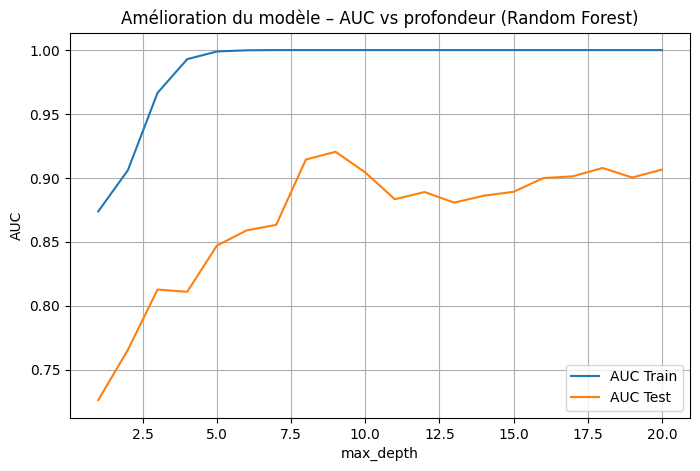

Meilleure profondeur = 9
AUC test max = 0.9204026567040267


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Liste des profondeurs testées
depths = range(1, 21)

auc_train = []
auc_test = []

for d in depths:
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=d,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Probabilités pour AUC
    y_train_proba = rf.predict_proba(X_train)[:, 1]
    y_test_proba  = rf.predict_proba(X_test)[:, 1]

    auc_train.append(roc_auc_score(y_train, y_train_proba))
    auc_test.append(roc_auc_score(y_test, y_test_proba))

# GRAPHIQUE
plt.figure(figsize=(8,5))
plt.plot(depths, auc_train, label="AUC Train")
plt.plot(depths, auc_test, label="AUC Test")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.title("Amélioration du modèle AUC vs profondeur (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

best_depth = depths[np.argmax(auc_test)]
print("Meilleure profondeur =", best_depth)
print("AUC test max =", max(auc_test))

# Résultats quantitatifs

Le modèle robuste obtient une accuracy de 99,2 % sur l’ensemble d’entraînement et de 84,39 % sur l’ensemble de test. La légère baisse de performance sur le jeu d’entraînement par rapport au modèle de base est un signe positif, indiquant une réduction du sur-apprentissage.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# MODÈLE RANDOM FOREST ROBUSTE
rf_robust = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)

rf_robust.fit(X_train, y_train)

# Prédictions (SANS scaling)
y_train_pred = rf_robust.predict(X_train)
y_test_pred  = rf_robust.predict(X_test)

print("Accuracy TRAIN :", accuracy_score(y_train, y_train_pred))
print("Accuracy TEST  :", accuracy_score(y_test, y_test_pred))

print("\nClassification report (TEST) :")
print(classification_report(y_test, y_test_pred))


Accuracy TRAIN : 0.992
Accuracy TEST  : 0.8439024390243902

Classification report (TEST) :
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       132
           1       0.74      0.86      0.80        73

    accuracy                           0.84       205
   macro avg       0.83      0.85      0.84       205
weighted avg       0.85      0.84      0.85       205

